In [49]:
import library as lib
import visualisation as viz

import string
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import swifter

from nltk.tokenize import casual_tokenize
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import LabelEncoder

from keras import layers
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K




import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
df = pd.read_csv('sampled_balanced_df.csv')

In [122]:
num_words = 20000
epochs = 10  
batch_size = 512  
sequence_len = 200  # Maximum number of words in a sequence
embedding_dimensions = 200

In [85]:
df.Text = df.Text.apply(lib.remove_stopwords, join=True)

In [86]:
df.Text.head()

0    [I, tried, jerky, fabulous!!!, Its, spicy, not...
1    [Let, say, I, like, medium, roast, coffee.., N...
2    [We, tried, purple,, green,, red, puffs,, like...
3    [I, actually, like, tea,, I, give, three, star...
4    [Oatmeal, raisin, cookies, favorite, type, coo...
Name: Text, dtype: object

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.Text, df.Score, test_size=0.2, random_state=42)

In [123]:
tk = Tokenizer(num_words=num_words,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [199]:
X_train_seq[0]

[1,
 1256,
 9,
 4356,
 83,
 9426,
 967,
 99,
 7828,
 3,
 4190,
 1650,
 9,
 25,
 7,
 1650,
 670,
 7,
 138,
 4046,
 15,
 1683,
 3,
 3443,
 1650,
 12189,
 1650,
 2,
 824,
 1650,
 407,
 17961,
 3,
 1650,
 15,
 4069,
 2573,
 1650,
 347,
 352,
 4898]

In [130]:
pickle.dump(tk, open( "tk_20k_vocab_200_words.pkl", "wb" ) )

In [89]:
X_train_seq[7]

[63,
 9858,
 184,
 155,
 73,
 66,
 16,
 78,
 5966,
 17,
 2660,
 142,
 27,
 291,
 414,
 6,
 43,
 125,
 13,
 170,
 190,
 912,
 190,
 230,
 11,
 8707,
 24,
 1,
 5082,
 358,
 310,
 222,
 132,
 6177]

In [124]:
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=sequence_len)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=sequence_len)

In [125]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [126]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_pad, y_train_oh, test_size=0.1, random_state=37)

In [200]:
y_train_emb

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [201]:
X_train_emb[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## Training Proprietary Embeddings

In [162]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(num_words, 200, input_length=sequence_len))
emb_model.add(layers.Conv1D(32,
                            5,
                            activation='relu',
                            input_shape=(200,1)))
emb_model.add(layers.GlobalMaxPooling1D())
emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(64,activation='relu',))
emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(5, activation='softmax'))
emb_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=[metrics.categorical_accuracy, lib.f1_m, lib.precision_m, lib.recall_m])
emb_history = emb_model.fit(X_train_emb,
                            y_train_emb,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_valid_emb, y_valid_emb))

Train on 65370 samples, validate on 7264 samples
Epoch 1/10
65370/65370 [==============================] - 37s 561us/step - loss: 1.4275 - categorical_accuracy: 0.3895 - f1_m: 0.0987 - precision_m: 0.3989 - recall_m: 0.0600 - val_loss: 1.2101 - val_categorical_accuracy: 0.4894 - val_f1_m: 0.3333 - val_precision_m: 0.6609 - val_recall_m: 0.2233
Epoch 2/10
65370/65370 [==============================] - 36s 553us/step - loss: 1.1217 - categorical_accuracy: 0.5377 - f1_m: 0.4369 - precision_m: 0.6767 - recall_m: 0.3242 - val_loss: 1.0770 - val_categorical_accuracy: 0.5496 - val_f1_m: 0.4626 - val_precision_m: 0.6746 - val_recall_m: 0.3523
Epoch 3/10
65370/65370 [==============================] - 38s 574us/step - loss: 0.9422 - categorical_accuracy: 0.6223 - f1_m: 0.5679 - precision_m: 0.7299 - recall_m: 0.4652 - val_loss: 1.0303 - val_categorical_accuracy: 0.5789 - val_f1_m: 0.5251 - val_precision_m: 0.6749 - val_recall_m: 0.4300
Epoch 4/10
65370/65370 [==============================] - 39

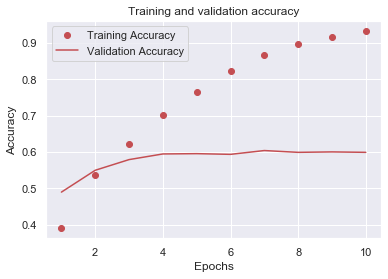

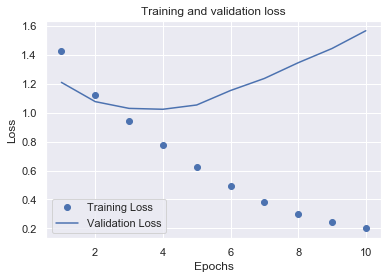

(None, None)

In [167]:
viz.plot_accuracy(emb_history), viz.plot_loss(emb_history)

In [196]:
emb_scores = lib.verbose_evaluate(emb_model, X_test_seq_pad, y_test_oh)

18159/18159 [==============================] - 4s 221us/step
The loss score is: 1.5364400170055397
The categorical_accuracy score is: 0.6049342155456543
The f1_m score is: 0.6060546040534973
The precision_m score is: 0.6280965209007263
The recall_m score is: 0.5861759185791016


In [187]:
emb_model.save('conv_embedding_model.h5')

In [190]:
emb_adam_model = models.Sequential()
emb_adam_model.add(layers.Embedding(num_words, 200, input_length=sequence_len))
emb_adam_model.add(layers.Conv1D(16,
                                 5,
                                 activation='relu',
                                 input_shape=(200,1)))
emb_adam_model.add(layers.GlobalMaxPooling1D())
emb_adam_model.add(layers.Dropout(0.5))
emb_adam_model.add(layers.Dense(32,activation='relu',))
emb_adam_model.add(layers.Dropout(0.2))
emb_adam_model.add(layers.Dense(5, activation='softmax'))
emb_adam_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=[metrics.categorical_accuracy, lib.f1_m, lib.precision_m, lib.recall_m])
emb_adam_history = emb_adam_model.fit(X_train_emb,
                            y_train_emb,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_valid_emb, y_valid_emb))

Train on 65370 samples, validate on 7264 samples
Epoch 1/10
65370/65370 [==============================] - 33s 505us/step - loss: 1.5522 - categorical_accuracy: 0.3085 - f1_m: 0.0103 - precision_m: 0.3006 - recall_m: 0.0053 - val_loss: 1.4485 - val_categorical_accuracy: 0.3838 - val_f1_m: 0.0385 - val_precision_m: 0.8114 - val_recall_m: 0.0197
Epoch 2/10
65370/65370 [==============================] - 31s 481us/step - loss: 1.3497 - categorical_accuracy: 0.4337 - f1_m: 0.2145 - precision_m: 0.6388 - recall_m: 0.1317 - val_loss: 1.2249 - val_categorical_accuracy: 0.4685 - val_f1_m: 0.2676 - val_precision_m: 0.7187 - val_recall_m: 0.1645
Epoch 3/10
65370/65370 [==============================] - 32s 489us/step - loss: 1.1895 - categorical_accuracy: 0.4973 - f1_m: 0.3706 - precision_m: 0.6619 - recall_m: 0.2581 - val_loss: 1.1606 - val_categorical_accuracy: 0.5040 - val_f1_m: 0.3768 - val_precision_m: 0.7037 - val_recall_m: 0.2576
Epoch 4/10
65370/65370 [==============================] - 31

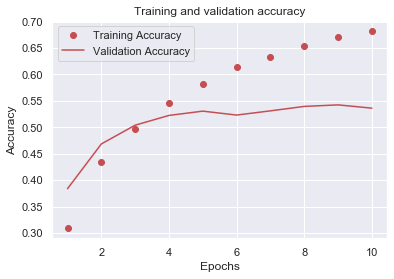

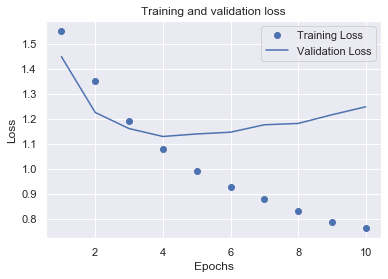

(None, None)

In [191]:
viz.plot_accuracy(emb_adam_history), viz.plot_loss(emb_adam_history)

In [194]:
emb_adam_scores = lib.verbose_evaluate(emb_adam_model, X_test_seq_pad, y_test_oh)

18159/18159 [==============================] - 3s 174us/step
The loss score is: 1.2201094538690602
The categorical_accuracy score is: 0.5444132089614868
The f1_m score is: 0.5150042176246643
The precision_m score is: 0.6470223069190979
The recall_m score is: 0.4305494427680969


### Comparison of the two models

In [197]:
emb_scores = list(emb_scores.values())
emb_adam_scores = list(emb_adam_scores.values())
loss = [emb_scores[0], emb_adam_scores[0]]
categorical_accuracy = [emb_scores[1], emb_adam_scores[1]]
f1 = [emb_scores[2], emb_adam_scores[2]]
precision = [emb_scores[3], emb_adam_scores[3]]
recall = [emb_scores[4], emb_adam_scores[4]]

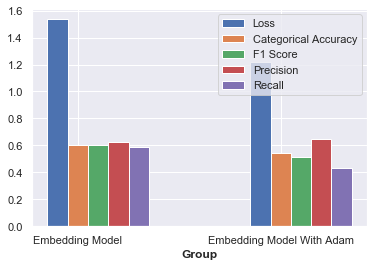

In [198]:
barWidth = 0.1

# Set position of bar on X axis
r1 = np.arange(len(loss))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, loss, width=barWidth, edgecolor='white', label='Loss')
plt.bar(r2, categorical_accuracy, width=barWidth, edgecolor='white', label='Categorical Accuracy')
plt.bar(r3, f1, width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r4, precision, width=barWidth, edgecolor='white', label='Precision')
plt.bar(r5, recall, width=barWidth, edgecolor='white', label='Recall')
 
# Add xticks on the middle of the group bars
plt.xlabel('Group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(loss))], ['Embedding Model', 'Embedding Model With Adam',])
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Previous Modelling Approach

In [5]:
%%time
stemmer = PorterStemmer()
corpus = [casual_tokenize(doc.lower()) for doc in df.Text]
corpus_sw = [lib.remove_stopwords(doc) for doc in corpus]
stemmed_corpus = []
for doc in corpus_sw:
    stemmed_corpus.append([stemmer.stem(word) for word in doc])

CPU times: user 1min 51s, sys: 1.01 s, total: 1min 52s
Wall time: 1min 59s


In [6]:
def dummy_func(doc):
    return doc

vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                             tokenizer=dummy_func, 
                             preprocessor=dummy_func, 
                             max_features=8000)
wv = vectorizer.fit_transform(stemmed_corpus)    

In [7]:
wv.shape[0] == len(df)

True

In [8]:
dense_wv = wv.toarray()
feature_names = vectorizer.vocabulary_
sorted_features = {k: v for k, v in sorted(feature_names.items(), key=lambda item: item[1])}
wv_df = pd.DataFrame(dense_wv, columns = sorted_features.keys())
wv_df['Target'] = df.Score

In [9]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label-1] = 1
    return results

In [10]:
X = wv_df.drop(columns='Target', axis=1)
y = wv_df.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

one_hot_train_labels = to_one_hot(y_train)
one_hot_test_labels = to_one_hot(y_test)

In [11]:
one_hot_train_labels[0]

array([0., 0., 1., 0., 0.])

In [12]:
x_val = X_train[:6800]
partial_x_train = X_train[6800:]
y_val = one_hot_train_labels[:6800]
partial_y_train = one_hot_train_labels[6800:]

In [13]:
print(partial_x_train.shape,partial_y_train.shape)
print(X_test.shape,one_hot_test_labels.shape)

(61294, 8000) (61294, 5)
(22699, 8000) (22699, 5)


In [14]:
partial_x_train.shape[1]

8000

In [15]:
simple_nn = models.Sequential()
simple_nn.add(layers.Dense(32, activation='relu', input_shape = (partial_x_train.shape[1], )))
simple_nn.add(layers.Dropout(0.4))
simple_nn.add(layers.Dense(32, activation='relu'))
simple_nn.add(layers.Dropout(0.25))
simple_nn.add(layers.Dense(5, activation='softmax'))

In [16]:
simple_nn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics = [metrics.categorical_accuracy])

In [17]:
nn_history = simple_nn.fit(partial_x_train,
                        partial_y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(x_val, y_val))


Train on 61294 samples, validate on 6800 samples
Epoch 1/10
61294/61294 [==============================] - 12s 198us/step - loss: 1.4929 - categorical_accuracy: 0.3669 - val_loss: 1.3014 - val_categorical_accuracy: 0.4459
Epoch 2/10
61294/61294 [==============================] - 8s 128us/step - loss: 1.2099 - categorical_accuracy: 0.4962 - val_loss: 1.1253 - val_categorical_accuracy: 0.5316
Epoch 3/10
61294/61294 [==============================] - 8s 130us/step - loss: 1.0921 - categorical_accuracy: 0.5495 - val_loss: 1.0889 - val_categorical_accuracy: 0.5474
Epoch 4/10
61294/61294 [==============================] - 9s 141us/step - loss: 1.0285 - categorical_accuracy: 0.5799 - val_loss: 1.0797 - val_categorical_accuracy: 0.5537
Epoch 5/10
61294/61294 [==============================] - 9s 154us/step - loss: 0.9886 - categorical_accuracy: 0.6005 - val_loss: 1.0795 - val_categorical_accuracy: 0.5560
Epoch 6/10
61294/61294 [==============================] - 10s 164us/step - loss: 0.9489 -